# Image segmentation of hand written digits 

In [1]:
# Importing libraries :

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

import os
import zipfile
import PIL.ImageFont , PIL.Image , PIL.ImageDraw

import  matplotlib.pyplot as plt

import requests
import io
import numpy as np

In [2]:
# Download zipped dataset

url = 'https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip'

response = requests.get(url, stream=True)

# Find and extract to a local folder ('/tmp/training')

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    
    zip_ref.extractall('/tmp/training')


 Load and process the dataset :

In [3]:
BATCH_SIZE = 32

def read_image_and_annotation(image, annotation):

  image = tf.cast(image, dtype=tf.float32)
  
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  
  annotation = tf.cast(annotation, dtype=tf.int32)
  
  image = image / 127.5
  
  image -= 1

  return image, annotation


def get_training_dataset(images, annos):

  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  
  training_dataset = training_dataset.batch(BATCH_SIZE)
  
  training_dataset = training_dataset.repeat()
  
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(images, annos):

  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):

  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  
  test_dataset = test_dataset.map(read_image_and_annotation)
  
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset


def load_images_and_segments():

  
  images = np.load('/tmp/training/combined.npy')
  
  segments = np.load('/tmp/training/segmented.npy')

  
  
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)
  

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)


In [4]:
def load_images_and_segments():
    
  images = np.load('/tmp/training/combined.npy')                 # load images and segmeentation mask
  
  segments = np.load('/tmp/training/segmented.npy')
  
  
  train_images , val_images , train_annos , val_annos = train_test_split(images , segments , test_size= 0.2 , shuffle= True)
  
  val_images , test_images , val_annos, test_annos = train_test_split(val_images , val_annos , test_size= 0.2 , shuffle= True)
  
  
  
  return (train_images , train_annos) , (val_images , val_annos) , (test_images , test_annos)

In [5]:
# Load dataset:

train_slices , val_slices , test_slices = load_images_and_segments()

training_dataset = get_training_dataset(train_slices[0] , train_slices[1] )

validation_dataset = get_validation_dataset(val_slices[0] , val_slices[1] )

test_dataset = get_test_dataset(test_slices[0] , test_slices[1] )



Visualizing data:

In [6]:
# Visualization Utilities

n_classes = 11

# assign a random color for each class

colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]


def fuse_with_pil(images):

  widths = (image.shape[1] for image in images)
  
  heights = (image.shape[0] for image in images)
  
  total_width = sum(widths)
  
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  
  for im in images:
      
    pil_image = PIL.Image.fromarray(np.uint8(im))
    
    new_im.paste(pil_image, (x_offset,0))
    
    x_offset += im.shape[1]
    
  return new_im


def give_color_to_annotation(annotation):

  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(n_classes):
      
    segc = (annotation == c)
    
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):

  new_ann = np.argmax(annotation, axis=2)
  
  true_img = give_color_to_annotation(new_ann)
  
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  
  image = image * 127.5
  
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  
  image = np.uint8(image)
  
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
      
    plt.subplot(1, 3, idx+1)
    
    if idx == 1:
        
      plt.xlabel(display_string)
      
    plt.xticks([])
    
    plt.yticks([])
    
    plt.imshow(im)


def show_annotation_and_image(image, annotation):

  new_ann = np.argmax(annotation, axis=2)
  
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  
  image = image * 127.5
  
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  
  images = [image, seg_img]
  
  images = [image, seg_img]
  
  fused_img = fuse_with_pil(images)
  
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):

  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  
  plt.title("Images And Annotations")
  
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
      
    plt.subplot(5, 5, idx + 1)
    
    plt.yticks([])
    
    plt.xticks([])
    
    show_annotation_and_image(image.numpy(), annotation.numpy())


C:\Users\PMLS\AppData\Local\Temp\ipykernel_11020\4053843237.py:130: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


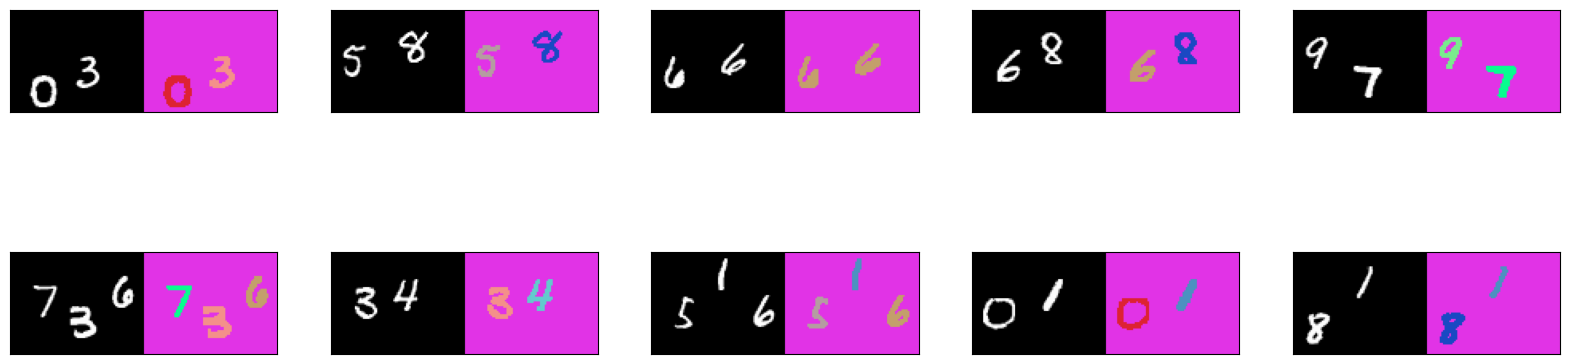

In [7]:
# get 10 images from the training set

list_show_annotation(training_dataset, 10)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_11020\4053843237.py:130: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


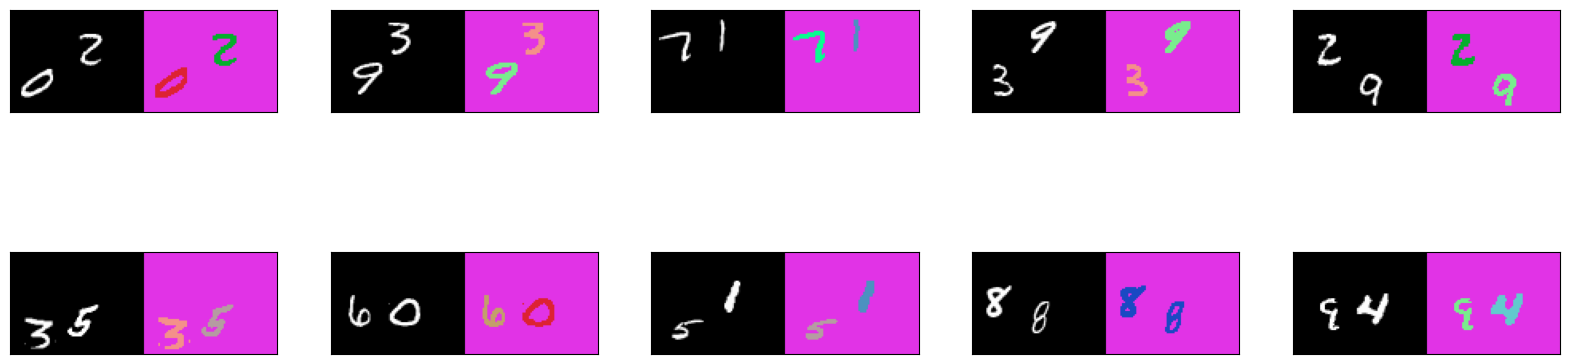

In [8]:
# get 10 images from the validation set

list_show_annotation(validation_dataset, 10)

FCN-8 Encoder

In [9]:
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, strides, pooling_size, pool_strides):

  x = tf.keras.layers.Conv2D(filters, strides, padding='same', data_format=IMAGE_ORDERING)(input)
  
  x = tf.keras.layers.LeakyReLU()(x)
  
  x = tf.keras.layers.Conv2D(filters, strides,padding='same')(x)
  
  x = tf.keras.layers.LeakyReLU()(x)
  
  x = tf.keras.layers.MaxPooling2D(pool_size=pooling_size,strides=pool_strides)(x)
  
  x = tf.keras.layers.BatchNormalization()(x)

  return x

In [10]:
def FCN8(input_height = 64 , input_width = 84):
    
    img_input = tf.keras.layers.Input(shape = ( input_height , input_width , 1))
    
    zero_padding = tf.keras.layers.ZeroPadding2D(((0 , 0) , (0 , 96 - input_width)))(img_input)
    
    b1 = conv_block(zero_padding , 32 , strides = (3 , 3 ) , pooling_size = (2 , 2) , pool_strides = (2 , 2))
    
    b2 = conv_block(b1 , 64 , strides = (3 , 3 ) , pooling_size = (2 , 2) , pool_strides = (2 , 2))
    
    b3 = conv_block(b2 , 128 , strides = (3 , 3) , pooling_size = (2 , 2) , pool_strides = (2 , 2))
    
    conv_block_3 = b3
    
    b4 = conv_block(b3 , 256 , strides = (3 , 3) , pooling_size = (2 ,2) , pool_strides = (2 , 2))
    
    conv_block_4 = b4
    
    b5 = conv_block(b4 , 512 , strides = (3 , 3) , pooling_size = (2 , 2) , pool_strides = (2 , 2))
    
    conv_block_5 = b5
    
    return (conv_block_3 , conv_block_4 , conv_block_5) , img_input
                                
    

FCN-8 Decoder

In [11]:
def FCN8_decoder(convs , n_classes):
        
    conv_block_3 , conv_block_4 , conv_block_5 = convs            # feature form encoder block
    
    n = 512                                                        # number of features
    
    # Add convolution layer on the top of CNN extractor
    
    o = tf.keras.layers.Conv2D(n , (7 , 7) , activation = 'relu' , padding = 'same' , name = 'conv_6', data_format = IMAGE_ORDERING)(conv_block_5)
    
    o = tf.keras.layers.Dropout(0.5)(o)
    
    o = tf.keras.layers.Conv2D(n , (1 ,1) , activation = 'relu' , padding = 'same' , name = 'conv_7' , data_format = IMAGE_ORDERING)(o)
    
    o = tf.keras.layers.Dropout(0.5)(o)
    
    
    #up sampling the image :
    
    o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size = (4 , 4), strides = (2 , 2), use_bias = False)(conv_block_5)
    
    o = tf.keras.layers.Cropping2D(cropping = (1 , 1))(o)                       # upsamples o and crop the extra pixels
    
    
    # load conv_block_4 and reshape it
    
    o2 = conv_block_4
    
    o2 = tf.keras.layers.Conv2D(n_classes , kernel_size = (1 , 1), activation = 'relu' , padding = 'same')(o2)
    
    
    # Adding the result of up_sampling and o2 :
    
    o = tf.keras.layers.Add()([o , o2])
    
    
    
    #  up_sampling the added layers:
    
    o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size = (4 , 4), strides = (2, 2) , use_bias = False)(o)
    
    o = tf.keras.layers.Cropping2D(cropping = (1 , 1))(o)
    
    
    
    # Adding the results :
    
    o2 = conv_block_3    
    
    o2 = tf.keras.layers.Conv2D(n_classes , (1 , 1) , activation = 'relu' , padding = 'same' , data_format = IMAGE_ORDERING) (o2)
    
    o = tf.keras.layers.Add()([o , o2])
    
    
    # 8x up_sampling:
    
    o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size = (8 , 8) , strides = (8 , 8) , use_bias = False)(o)
    
    o = tf.keras.layers.Cropping2D(((0 , 0) , (0 , 96 - 84)))(o)
    
    
    o = tf.keras.layers.Activation('sigmoid')(o)
    
    return o
    

Defining the complete model

In [12]:
convs , img_input = FCN8()      # Encoder

dec_op = FCN8_decoder(convs , n_classes)        # Decoder


#Define the model:

model = tf.keras.Model(inputs = img_input , outputs = dec_op)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 84, 1)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 64, 96, 1)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 64, 96, 32)           320       ['zero_padding2d[0][0]']      
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 96, 32)           0         ['conv2d[0][0]']          

In [14]:
model.compile(loss = 'binary_crossentropy' , optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001) , metrics = ['accuracy'])

Model training :


In [16]:
EPOCHS = 5

steps_per_epoch = 4000 // BATCH_SIZE

validation_steps = 800 // BATCH_SIZE

test_steps = 200 // BATCH_SIZE


history = model.fit(training_dataset , 
                    
                    steps_per_epoch = steps_per_epoch ,
                    
                    validation_data = validation_dataset ,
                    
                    validation_steps = validation_steps ,
                    
                    epochs = EPOCHS)

Epoch 1/5


125/125 [==============================] - 82s 655ms/step - loss: 0.0322 - accuracy: 0.9425 - val_loss: 0.0469 - val_accuracy: 0.9426
Epoch 2/5
125/125 [==============================] - 81s 645ms/step - loss: 0.0285 - accuracy: 0.9425 - val_loss: 0.0358 - val_accuracy: 0.9426
Epoch 3/5
125/125 [==============================] - 80s 636ms/step - loss: 0.0261 - accuracy: 0.9432 - val_loss: 0.0266 - val_accuracy: 0.9435
Epoch 4/5
125/125 [==============================] - 84s 669ms/step - loss: 0.0243 - accuracy: 0.9452 - val_loss: 0.0237 - val_accuracy: 0.9461
Epoch 5/5
125/125 [==============================] - 80s 639ms/step - loss: 0.0220 - accuracy: 0.9494 - val_loss: 0.0216 - val_accuracy: 0.9491


Testing the model :

In [17]:
results = model.predict(test_dataset , steps = test_steps)

print(results.shape)

6/6 [==============================] - 3s 127ms/step
(192, 64, 84, 11)


In [ ]:
results = np.argmax(results , axis = 2)

print(results.shape)

print(results[0 , : ])           #Prediction map for image 0

In [27]:
def class_wise_metrics(y_true , y_pred):
    
    class_wise_iou = []
    
    class_wise_dice_score = []
    
    smoothing_factor = 0.00001
    
    for i in range(n_classes):
        
        intersection = np.sum((y_pred == i) * (y_true == i).T)
        
        y_true_area = np.sum((y_true==i)) 
        
        y_pred_area = np.sum((y_pred==i))
        
        combined_area = y_pred_area + y_true_area
        
        iou = (intersection) / (combined_area - intersection + smoothing_factor)
        
        class_wise_iou.append(iou)
        
        
        
        dice_score = 2 * ((intersection) / combined_area + smoothing_factor)
        
        class_wise_dice_score.append(dice_score)
        
        
        return class_wise_iou , class_wise_dice_score
        

Visualizing the outputs :

In [ ]:
# place a number here between 0 to 191 to pick an image from the test set
integer_slider = 105

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image
  
  
iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])  
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


In [ ]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score)) 
  average_iou += iou

grade = average_iou * 10

print("\nGrade is " + str(grade))

PASSING_GRADE = 60
if (grade>PASSING_GRADE):
  print("You passed!")
else:
  print("You failed. Please check your model and re-train")